In [1]:
# import PyPDF2
# import spacy
import numpy as np
import pandas as pd
import fitz
import nltk

from nltk.tokenize import sent_tokenize
# from pathlib import Path

import os

# nlp = spacy.load('en_core_web_lg')

In [2]:
# sent_list = []

# for page in pdf_text[2:]:
#     doc = nlp(page)
#     for sentence in doc.sents:
#         sent_list.append(sentence)

In [3]:
path_pdf = 'C:\\Users\\tnguyen10\\OneDrive - Deloitte (O365D)\\Documents\\GitHub\\Thesis\\data\\reports'
fname_out = 'C:\\Users\\tnguyen10\\OneDrive - Deloitte (O365D)\\Documents\\GitHub\\Thesis\\data_structured\\report_sentences.csv'

In [4]:
def get_cnt(text):
    cnt = 0
    for word in text.split():
        if word.isalnum():
            cnt += 1
    return cnt

In [5]:
def get_text(block_lst):

    MIN_WORD_CNT = 6
    
    text_lst = []
    for block in block_lst:
        if block[6] != 0: continue # block_type: 0 = text
        
        #I'm replacing the non-ascii single quotation mark here, because it's used in Coca Cola's report
        text = block[4].replace('’',"'")
        text = ''.join([i if ord(i) < 128 else ' ' for i in text])
        #text = text.replace('fi ', 'fi') # PyMuPDF(fitz) bug fix: 'fi ' --> 'fi'
    
        if get_cnt(text) < MIN_WORD_CNT: continue # Delete sentences with less than MIN_WORD_CNT(10) 
    
        text_lst.append(text.replace('-\n', ''))
        #.replace('-\n', '')
    return ('\n'.join(text_lst))

In [6]:
# test_sent = sent_tokenize(text)[2]

# r_sent = ' '.join(test_sent.split()) #split splits the words of the sentence into a list - and gets rid of /n etc.

# ' '.join(test_sent.split()) #joins the items of the list with a space 

In [7]:
def get_sentence(fname, skip_page = (0,)):
 
    doc = fitz.open(fname)
    
    sent_lst = []
    for page_no, page in enumerate(doc):

        # Skip page
        if page_no in skip_page: continue
        
        block_lst = page.get_text_blocks()
        text = get_text(block_lst)
    
        for i, sentence in enumerate(sent_tokenize(text)):
            r_sent = ' '.join(sentence.split()) # Delete '\n', '\t' and strip
            sent_lst.append(r_sent)
            
    doc.close()

    return sent_lst

In [8]:
def gen_document(fname, sent_lst):

    res_df = pd.DataFrame(
        {
            'doc_type': 'report',
            'fname': fname.split('.')[0],
            'sentence': sent_lst
        }
    )
    
    return res_df

In [9]:
def read_filelist(path):

    # Create empty DataFrame
    df = pd.DataFrame()
    
    # Read file list (directory)
    for idx, fname in enumerate(os.listdir(path)):
        p_fname = os.path.join(path, fname)
        print('path + fname >>>', p_fname)
        
        if p_fname.split('.')[-1] != 'pdf': continue
        print('fname >>>',fname)
    
#         doc_id = int(idx)
        
#         print(f'doc_id = [{doc_id}], fname = [{fname}]')
#         print('')
    
        sent_lst = get_sentence(p_fname)
        df_doc   = gen_document(fname, sent_lst)
        
        df = pd.concat([df,df_doc])
        
    return df

In [10]:
%%time
df = read_filelist(path_pdf)
print('==== End of jobs ====')

path + fname >>> C:\Users\tnguyen10\OneDrive - Deloitte (O365D)\Documents\GitHub\Thesis\data\reports\abb.pdf
fname >>> abb.pdf
path + fname >>> C:\Users\tnguyen10\OneDrive - Deloitte (O365D)\Documents\GitHub\Thesis\data\reports\adidas.pdf
fname >>> adidas.pdf
path + fname >>> C:\Users\tnguyen10\OneDrive - Deloitte (O365D)\Documents\GitHub\Thesis\data\reports\airbus.pdf
fname >>> airbus.pdf
path + fname >>> C:\Users\tnguyen10\OneDrive - Deloitte (O365D)\Documents\GitHub\Thesis\data\reports\apple.pdf
fname >>> apple.pdf
path + fname >>> C:\Users\tnguyen10\OneDrive - Deloitte (O365D)\Documents\GitHub\Thesis\data\reports\bayer.pdf
fname >>> bayer.pdf
path + fname >>> C:\Users\tnguyen10\OneDrive - Deloitte (O365D)\Documents\GitHub\Thesis\data\reports\beiersdorf.pdf
fname >>> beiersdorf.pdf
path + fname >>> C:\Users\tnguyen10\OneDrive - Deloitte (O365D)\Documents\GitHub\Thesis\data\reports\blackrock.pdf
fname >>> blackrock.pdf
path + fname >>> C:\Users\tnguyen10\OneDrive - Deloitte (O365D)\D

In [11]:
df['sentence'].values[1507]

"This is a revolutionary advancement in the manufacturing of one of the world's most widely used metals."

In [12]:
df.to_csv(fname_out, index = False)

In [13]:
df.values[14]

array(['report', 'abb',
       'We continued to train, coach and assess selected high-risk suppliers on sustainability topics, keeping us on track towards our goal of covering 80 percent of supply chain spend in focus countries by 2030.'],
      dtype=object)

In [30]:
df['sentence'].values[6]

'A second goal of our 2030 sustainability strategy is to preserve resources at every stage of the value chain.'

# Further cleaning

In [15]:
df_report = df

In [16]:
df_report["sentence"] = df_report["sentence"].replace(r'http\S+|\[.\]:?|www\S+|\w+/\S+|\w+-\w+-\S+','',regex = True).replace(r'^\s+|\s+$','',regex=True).replace(r'\s{2,}',' ',regex=True)

In [17]:
df_report['sentence'] = df_report['sentence'].str.replace('Nestl ', 'Nestle ')

In [18]:
df_report["word count"] = [len(i) for i in df_report["sentence"].str.split()]

In [19]:
df_report = df_report[df_report["word count"] > 5]

In [20]:
df_report = df_report[df_report["word count"] < 100]

array([[<Axes: title={'center': 'word count'}>]], dtype=object)

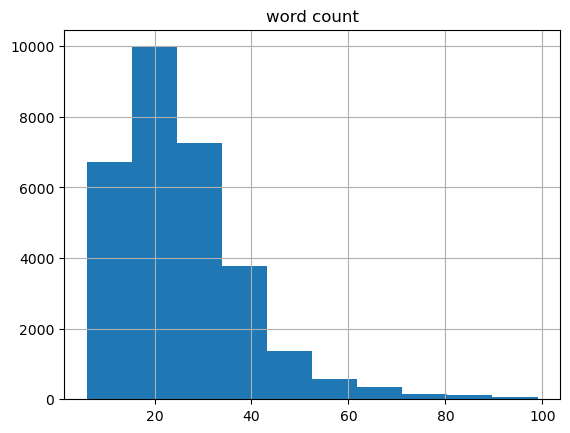

In [21]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
df_report.hist(column = 'word count')

In [22]:
df_report

,doc_type,fname,sentence,word count
0,report,abb,customers to deliver annual savings of 100 meg...,13
1,report,abb,"In the coming years, we expect savings of GHG ...",25
2,report,abb,ABB has assessed the extent to which our activ...,27
3,report,abb,We found that 36 percent of our revenue in 202...,19
4,report,abb,We consider this to be a significant underesti...,33
...,...,...,...,...
152,report,walmart,LABS works with engineering companies to devel...,20
153,report,walmart,Factories develop supervised corrective action...,18
154,report,walmart,LABS has been active in India and Vietnam sinc...,14
155,report,walmart,The program expanded to Cambodia in May 2022 a...,17


In [23]:
df_report.to_csv(fname_out, index = False)